cornernet发表于18年的论文"CornerNet: Detecting Objects as Paired Keypoints"，提出了一种anchor-free的网络架构，通过预测一对关键点（左上角与右下角）来预测bounding box。性能超过了当时的所有one-stage方法。

作者认为,传统的anchor-based目标检测方法，有大量的anchors，会造成严重的正负样本不均衡，且anchor的应用引入了大量超参数，如size,ratio。文章受启发于人体关键点检测，用关键点来预测bbox，与传统的方法有以下优势：<br/>
1)一个角点只与两条边有关，而中点与4条边有关，因此角点易于预测<br/>
2)通过角点来做密集预测效率较高，只需要o(wh)个corner，就能产生$o(w^2h^2)$个可能的anchors

cornernet整体架构如下几图所示，backbone为两个堆叠的hourglass结构，从backbone出来的特征图,被送入两个分支，一个左上角分支，一个右下角的分支。以左上角分支举例，特征图首先被送入corner pooling，分为top与left两路，分别做top pooling与left pooling，然后两路add输入一个特征图，同时接一个shorcut连接，再次add产生新的特征图，随后经过conv层产生heatmaps，embeddings与offsets。右下角分支同理。
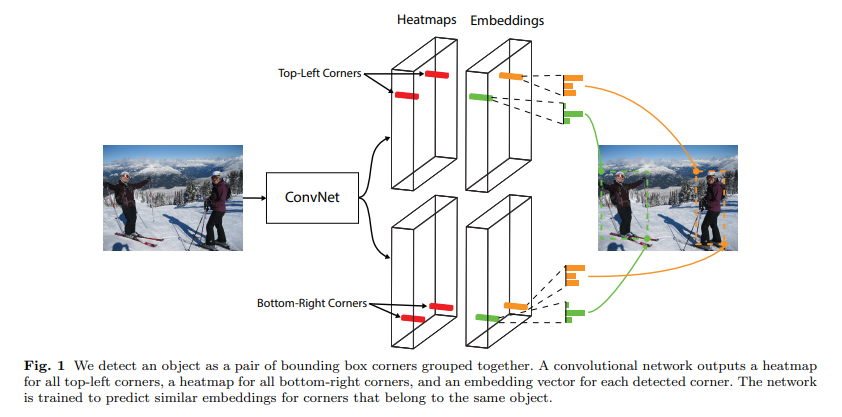

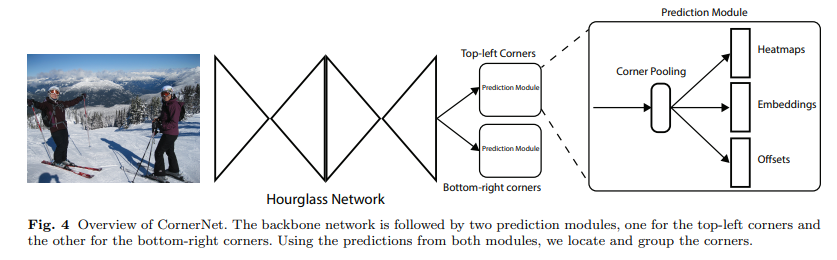

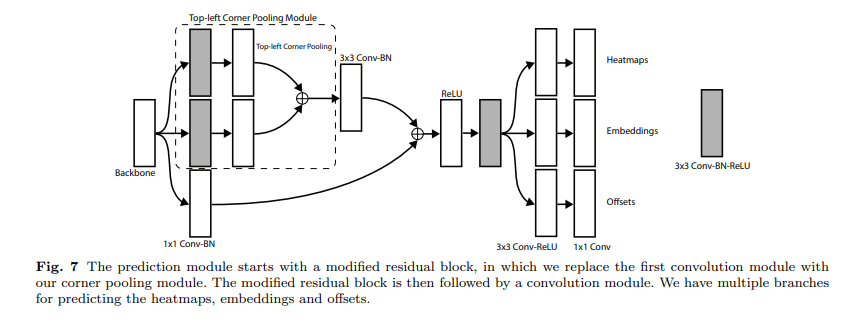

hourglass<br/>
hourglass结构如下，首先经过若干次下采样，然后经过相同数量的上采样，在下采样过程中，局部信息会丢失，因此加了短路连接，这样就能保证保留大多局部与全局信息。cornernet对hourglass结构做了一些修改。
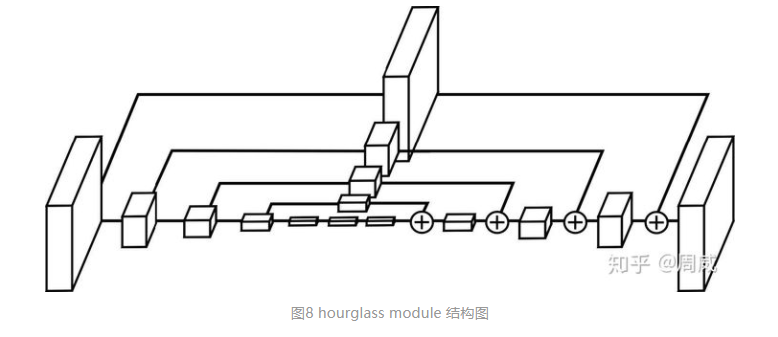

corner pooling<br/>
如下图所示，一般角点很难通过局部特征来判断，因此判断一个位置是否是角点，需要从它的位置平行往右看找上边界，再垂直往下看，找左边界。因此，作者提出cornerpooling来帮助网络定位左上角与右下角。以左上角为例，用动态规划自右向左、自下向上即可得到左、上pooling的结果。
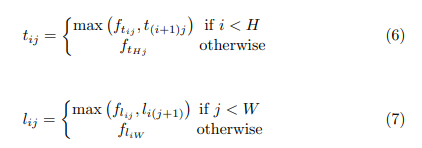

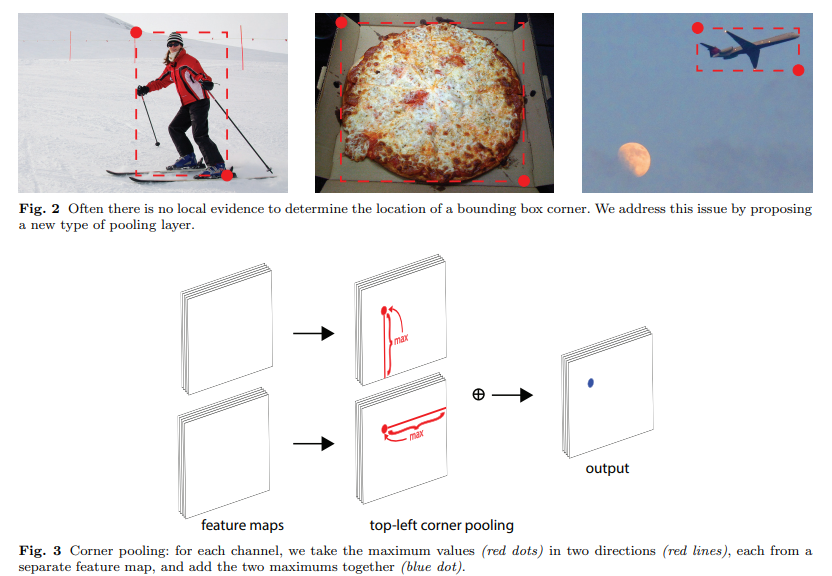

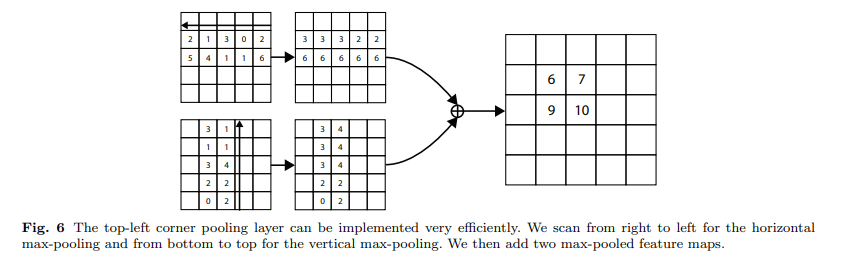

推理<br/>
网络输入是511x511x3（保持长宽比加黑边），以左上角为例，得到的heatmap是128x128x80，offsets是128x128x2，embedding是128x128x1。heatmap的值是用sigmoid得出，表示是角点的概率，offset的两维分别为左、上角点的偏移，embedding是一个数值，用于计算距离。首先用NMS（非极大抑制，这里的NMS与传统的不同，是用maxpooling实现的）抑制非极大值，然后选出前100个score最大的左角点与100个score最大的上角点。然后加上他们的偏移。然后，用L1 loss分别计算左角点与上角点的距离（首先排除不是同一个类别的），然后过滤掉distance<0.5的。角点对最终的score为左角点score与上角点score的均值。在输出最终结果时，可用该score进行过滤。

测试<br/>
作者在测试时分别用了原图与flip图，然后用soft-nms进行非极大抑制，最终一张图只输出100个预测结果。

训练<br/>
$对于heatmap，在ground true的角点处gt为1，此外，在以ground true为中心，以r为半径的圆\\内，gt值通过高斯分布向外递减，r的取值标准：在圆内的角点对构成的bbox与标签bbox的iou\\不小于某个阈值，文中设为0.3。高斯分布为e^{-\frac{x^2+y^2}{2\delta^2}}，\\ \delta=1/3。在圆外的gt值为0.设置圆的目的是因为在圆内的点也能与gt有不错的iou:$
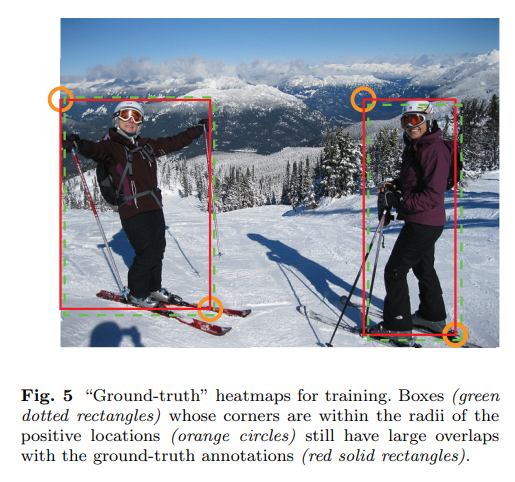

heatmap的loss是一个改进版的focal loss:
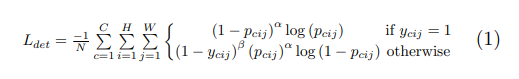
$其中，N为一张图像中的目标数量，\alpha、\beta是超参数，文中设\alpha=2,\beta=4$

offset的标签为ground truth映射回input的偏差，这个ground truth是在圆内的角点，只有在圆内的预测值才计算loss:
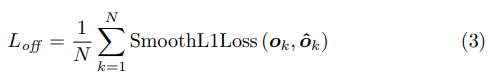

其中，
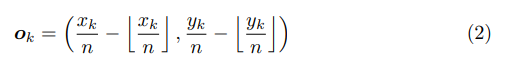

对于embeddings,不需要标签，loss函数包括pull loss与push loss，pull loss拉近两个角点，push loss分离两个角点：
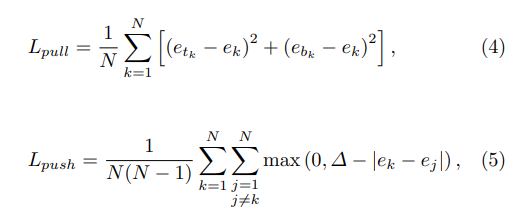
$其中e_{t_k}为第k个目标左上角点的embedding，e_{b_k}为第k个目标右下角点的embedding，\\ e_k为二者的均值。\delta在文中设为1$

最终的loss为三者的和：
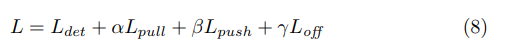
$文中设\alpha=\beta=0.1,\gamma=1$